In [1]:
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
import pandas as pd
import ssl
import spacy
ssl._create_default_https_context = ssl._create_unverified_context

In [34]:
import os
import json
import sys
import re
from smart_open import smart_open
from gensim.downloader import base_dir


nlp = spacy.load('en_core_web_sm')

read_list = []

path = os.path.join(base_dir, '20-newsgroups', "20-newsgroups.gz")
with smart_open(path, 'rb') as infile:
    for record in infile:
        read_list.append(json.loads(record))

df20News = pd.DataFrame.from_records(read_list)

sentences_corpus = []

for index, row in df20News.iterrows():
    if index % 100 == 0:
        print(index)
    text = row['data']
    doc = nlp(text)  
    for sent in doc.sents:
        sentences_corpus.append([token.lemma_.lower() for token in sent if not token.is_stop and token.is_alpha])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [35]:
# Importujemy moduł, który pozwoli na sprawdzenie liczby rdzeniu CPU
import multiprocessing

cores = multiprocessing.cpu_count()
cores

8

In [36]:
# Wielkość wektora wyjściowego
embedding_size = 50

# Maksymalna odległość między bieżącym a przewidywanym słowem w zdaniu.
window_size = 5

# Minimalna liczba wystąpień słowa w korpusie, które należy uwzględnić w modelu.
# Im wyższa liczba, tym mniej słów mamy w naszym ciele
min_word = 1

# Model CBOW (0) lub skip-gram (1)
sg = 0

# Liczba iteracji (epok) uczenia sieci
iterations = 2

# Ustawienie stałej wartości zapobiega losowości wyników
# przy każdorazowym uruchomieniu
random_state = 42

# 0 negative sampling lub 1 hierarchiczny softmax
hs = 1

In [37]:
# Klasy pomocniczne, które pozwolą na wypisywanie startu/końca
# uczenia kolejnej iteracji modelu Word2Vec
from gensim.models.callbacks import CallbackAny2Vec


class EpochSaver(CallbackAny2Vec):
    """Callback to save model after each epoch."""
    def __init__(self, path_prefix):
        self.path_prefix = path_prefix
        self.epoch = 0

    def on_epoch_end(self, model):
        output_path = get_tmpfile(f'{self.path_prefix}_epoch{self.epoch}.model')
        
        model.save(output_path)

        self.epoch += 1


class EpochLogger(CallbackAny2Vec):
    """Callback to log information about training."""
    def __init__(self):
        self.epoch = 0
    
    def on_epoch_begin(self, model):
        print(f"Epoch #{self.epoch} start")
    
    def on_epoch_end(self, model):
        # If hs=1 then loss component corresponding to hierarchical softmax
        # else loss component corresponding to negative sampling
        # loss = model.get_latest_training_loss()

        # print("Epoch #{} end with loss: {:.2f}".format(self.epoch, loss))
        print(f"Epoch #{self.epoch} end")
        self.epoch += 1

In [38]:
epoch_logger = EpochLogger()

# To może potrwać kilka minut
model = Word2Vec(
    sentences_corpus,
    size=embedding_size,
    window=window_size,
    min_count=min_word,
    sg=sg,
    iter=iterations,
    seed=random_state,
    hs=hs,
    workers=cores,
    callbacks=[epoch_logger]
)

Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end


In [39]:
model.save('model-w2v-cbow.bin')

In [40]:
vocabulary = set(model.wv.index2word)
words = list(model.wv.vocab)

len(vocabulary) == len(words), len(vocabulary)

(True, 76172)

In [41]:
from typing import List

import numpy as np


def average_word_vectors(model: Word2Vec, words: List, vocabulary: set) -> np.array:
    """
    Method return NumPy array as a Average Word Vectors
    """
    
    words: list = [word for word in words if word in vocabulary]

    if words:
        feature_vector: np.array = np.mean(
            model.wv[words],
            axis=0,
            dtype="float64"
        )
    else:
        feature_vector: np.array = np.zeros(
            (model.vector_size,),
            dtype="float64"
        )

    return feature_vector


def word_normalization(word: str) -> str:
    """
    Word normalization by removing "white chars" and lowering it
    """
    
    return word.strip().lower()

### Zadanie 1

In [42]:
model.wv.word_vec('python')

array([-0.09833478,  0.1425009 ,  0.22438635, -0.04965596, -0.20659858,
        0.17390585,  0.11089459,  0.16279934, -0.02024491, -0.14275764,
       -0.20162317,  0.06024716, -0.16846159, -0.13686574,  0.09437556,
        0.11898863,  0.10310286, -0.05074783,  0.30350715,  0.00610311,
       -0.19644311, -0.17471276,  0.1977462 , -0.19816767,  0.07887521,
       -0.0354114 , -0.0525753 , -0.057479  , -0.29074043,  0.18460892,
        0.05378341, -0.1217956 ,  0.21839888,  0.17038597,  0.17741616,
        0.05682572,  0.25229126,  0.33775797,  0.12778266,  0.04147685,
       -0.0517571 ,  0.17921944, -0.26878074,  0.01272425, -0.04459994,
        0.00528481, -0.04831876,  0.02179734,  0.05695647,  0.0643986 ],
      dtype=float32)

In [43]:
import pandas as pd
import numpy as np

data_list = []
for word in vocabulary:
    seq_as_words = list(map(word_normalization, word.split()))
    seq_avg_vector = average_word_vectors(model, seq_as_words, vocabulary)
    data_list.append(seq_avg_vector)
    
data = np.vstack(data_list)
df = pd.DataFrame(data=data)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.020591,0.000633,-0.009594,0.009289,-0.013258,0.001541,0.010682,0.016136,-0.000757,0.040257,...,-0.026155,0.010652,-0.000258,0.017933,-0.013131,-0.015923,-0.005616,0.023056,-0.005300,0.000123
1,-0.086399,-0.001301,-0.008081,-0.052468,-0.033288,0.022888,0.008774,-0.027513,-0.006527,-0.010869,...,-0.132009,-0.037780,-0.134478,-0.067769,-0.103314,0.068596,0.199128,-0.144207,-0.002581,-0.035460
2,0.075293,0.035324,0.021803,0.011003,-0.008652,-0.045598,-0.025208,0.121888,0.012121,-0.037359,...,-0.046711,-0.005466,0.020949,-0.109901,0.063326,0.039364,-0.111916,0.158293,-0.023077,0.149034
3,-0.011196,-0.103891,-0.043628,0.064636,0.049972,-0.023560,-0.019589,0.028816,-0.025506,-0.017140,...,-0.019384,0.029602,-0.051860,-0.029308,0.027239,-0.063819,-0.020493,-0.026045,-0.008431,-0.012771
4,-0.012556,-0.009725,0.029292,-0.011472,-0.003167,-0.012131,0.016732,0.044781,-0.005518,-0.038432,...,-0.072367,-0.046256,-0.095253,-0.023658,0.030297,0.031885,0.067213,0.046456,-0.026820,-0.033914


In [44]:
df.shape

(76172, 50)

### Zadanie 2

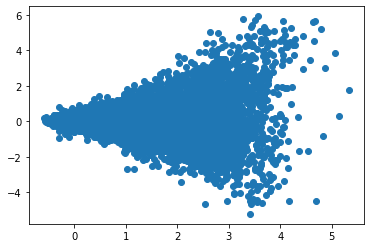

In [45]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(
    n_components=2,
    random_state=random_state
)

result = pca.fit_transform(df)

fig, ax = plt.subplots()
ax.scatter(result[:, 0], result[:, 1])

#for i, txt in enumerate(vocabulary):
#    x, y = result[i, 0], result[i, 1]
#    ax.annotate(txt, [x, y])

### Zadanie 3

In [75]:
from gensim.models import FastText
epoch_logger = EpochLogger()
modelFastText = FastText(size=embedding_size, window=5, min_count=1,
                    sentences=sentences_corpus,
                    iter=10,
                    workers = cores,
                    callbacks=[epoch_logger])


Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end
Epoch #5 start
Epoch #5 end
Epoch #6 start
Epoch #6 end
Epoch #7 start
Epoch #7 end
Epoch #8 start
Epoch #8 end
Epoch #9 start
Epoch #9 end


### Zadanie 4

In [127]:
model.wv.wmdistance('apple juice is realy good'.split(), 'oranges and apples are tasty'.split())

3.4969088467906713

In [126]:
modelFastText.wv.wmdistance('apple juice is realy good'.split(), 'oranges and apples are tasty'.split())

3.5350884556236264

### Zadanie 5

In [120]:
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

df5 = pd.read_csv('hate_speech_twitter.csv')
nlp = spacy.load('en_core_web_sm')
df5.head()


,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [151]:
documents = []

for index, row in df5.iterrows():
    if index % 100 == 0:
        print(index)
    text = row['tweet']
    doc = nlp(text)  
    doc_prepared = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]
    documents.append(TaggedDocument(doc_prepared, ['TWEET_%s' %index]))
    
documents[0]

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

TaggedDocument(words=['rt', 'woman', 'complain', 'clean', 'house', 'amp', 'man', 'trash'], tags=['TWEET_0'])

In [152]:
epoch_logger = EpochLogger()
modelDoc2Vec = Doc2Vec(documents, size=embedding_size, window=5, min_count=1,
                    iter=10,
                    workers = cores,
                    callbacks=[epoch_logger])

Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end
Epoch #5 start
Epoch #5 end
Epoch #6 start
Epoch #6 end
Epoch #7 start
Epoch #7 end
Epoch #8 start
Epoch #8 end
Epoch #9 start
Epoch #9 end


In [153]:
modelDoc2Vec.infer_vector(['cos', 'tam'])

array([-0.03295977,  0.02218305, -0.01872486, -0.00047626, -0.00376105,
        0.01739749,  0.03363158,  0.01445866,  0.01047152, -0.020078  ,
       -0.01636694, -0.01998172, -0.00483465, -0.02766092,  0.01892491,
       -0.01514195, -0.02061551,  0.03756815, -0.00869711, -0.00962509,
       -0.02556566,  0.02854254,  0.02634089, -0.03745816,  0.00362752,
       -0.00511962, -0.01271562,  0.02870048,  0.00750841,  0.04548075,
        0.03161416, -0.00901211, -0.00375855, -0.02964339,  0.01864301,
       -0.0274958 , -0.00680135, -0.02104076, -0.00300454,  0.01090271,
       -0.01586366, -0.00653857,  0.00655571,  0.00138997, -0.01906078,
        0.01602436,  0.00620148, -0.00609072, -0.00461576,  0.01281467],
      dtype=float32)

In [168]:
vectorized_tweets = []
for idx in range(0,df5.shape[0]):
    vectorized_tweets.append(modelDoc2Vec.docvecs['TWEET_%s' %idx])

df5['vector'] = vectorized_tweets

df5.to_csv("doc2vec_tweets.csv", index=False, sep=',')
df5.head()

,class,tweet,vector
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,"[0.005514013, 0.0113683175, -0.0035790561, -0...."
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,"[-0.0723158, 0.01798391, -0.05348623, 0.018083..."
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,"[-0.017072294, 6.9012975e-05, -0.0064990325, -..."
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,"[0.004695186, -0.0067790104, -0.003710715, -0...."
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,"[-0.011278763, -0.009382275, 0.0050429427, 0.0..."


In [170]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

train, test = train_test_split(df5, test_size = 0.3)

In [175]:
train_y = train['class']
train_x = pd.DataFrame(train['vector'].to_list())
test_y = test['class']
test_x = pd.DataFrame(test['vector'].to_list())

In [178]:
clf = MLPClassifier(solver='adam', activation='relu', random_state=0) # domyślne ustawienia

In [179]:
clf.fit(train_x, train_y)

MLPClassifier(random_state=0)

In [184]:
print('Accuracy:', clf.score(test_x, test_y))

Accuracy: 0.8106254203093477


In [189]:
from sklearn.metrics import confusion_matrix

test_prediction = clf.predict(test_x)

cm = confusion_matrix(test_y, test_prediction)
cm_labels = ["nienawistna ", "wulgarna ","neutralna "]
df_cm = pd.DataFrame(cm, index = cm_labels,
                  columns = cm_labels)
df_cm

,nienawistna,wulgarna,neutralna
nienawistna,3,382,55
wulgarna,2,5478,281
neutralna,0,688,546


### Zadanie 6
Issue z githuba gensim, w którym zawarta jest informacja o maksymalnej liczbie 10 000 tokenów w zdaniu [link](https://github.com/RaRe-Technologies/gensim/issues/2880)

[Link](https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/word2vec.py) do kodu źródłowego word2vec.py.

Znajduje się tam zaimportowana stała MAX_WORDS_IN_BATCH (linia 212), która równa jest MAX_SENTENCE_LEN ([link](https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/word2vec_inner.pyx) plik word2vec_inner.pyx).

MAX_SENTENCE_LEN z kolei jest równa 10 000 ([link](https://github.com/RaReTechnologies/gensim/blob/develop/gensim/models/word2vec_inner.pyx) - linia 31)